# 실습: 음성 데이터 전처리 구현

본 실습의 목표는 음성 도메인의 다양한 테스크에서 사용되는 음성 데이터 전처리 방법에 대한 학습입니다. 먼저 명세서에서 제시해준 블로그를 통해 데이터 전처리에 대한 기본 지식을 습득한 뒤 아래 셀들을 실행하면서, 각 부분이 어떻게 동작하는지 실습을 진행합니다.




### 라이브러리 import
먼저 필요한 라이브러리들을 import합니다.
음성 데이터 전처리시 가장 많이 사용하는 라이브러리는 ``librosa'' 입니다.

**references**\
librosa doc:\
https://librosa.org/doc/latest/index.html


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydub
from pydub import AudioSegment
import librosa, librosa.display 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import Audio
import torch.nn as nn
import torch.nn.functional as F
import torch
from librosa.filters import mel as librosa_mel_fn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 음성 파일 load
librosa 라이브라이 내에 load 함수를 활용하여 음성 파일로 부터 waveform을 불러올수 있습니다.

**references**\
https://librosa.org/doc/main/generated/librosa.load.html


In [3]:
test_audio = "/content/drive/My Drive/Colab Notebooks/SubPJT2_Voice_Conversion/jupyter/source/test.wav" 
sig, sr = librosa.load(test_audio, sr=22400)

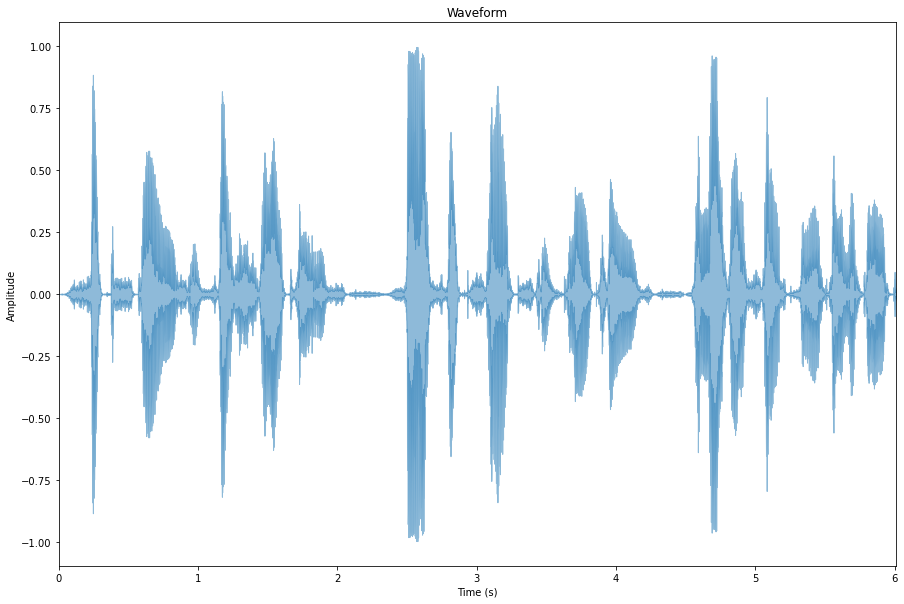

In [4]:
# load한 음성 시각화
FIG_SIZE = (15,10)
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(sig, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
Audio(data=sig, rate=22400)

### Mel-spectrogram을 만드는 과정은 다음과 같습니다.
1) Windowing
2) Short time fourier transform(STFT)
3) Mel-filter bank
4) Logarithm function에 넣기

(자세한 내용은 명세서에서 제공해준 블로그를 참고하세요)

### 퓨리에 변환으로 스펙트럼 구하기

Text(0.5, 1.0, 'Power spectrum')

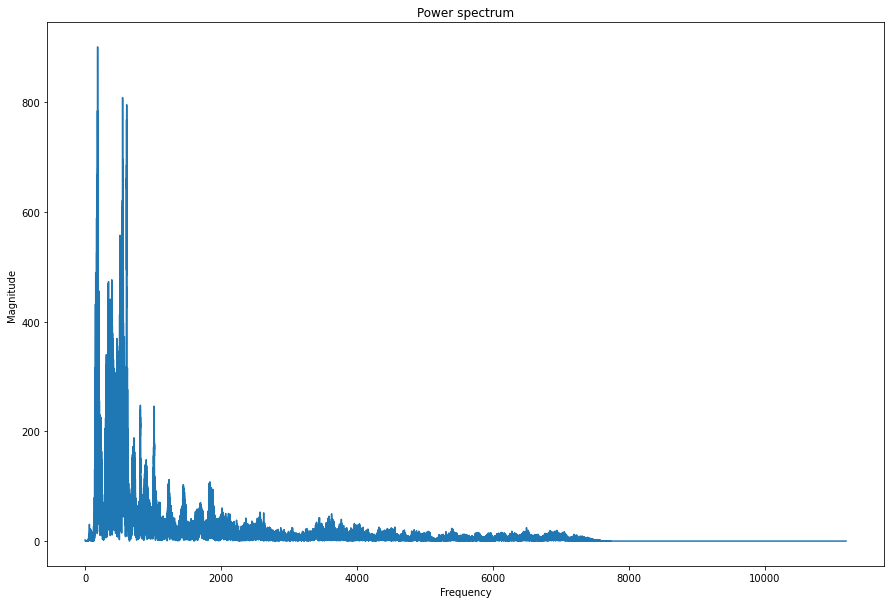

In [5]:
# 단순 퓨리에 변환으로 스펙트럼 구하기
fft = np.fft.fft(sig)

# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft) 

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

###STFT를 사용하여 spectrogram 생성하기
librosa 라이브라이 내에 stft 함수를 활용하여 음성 파일로 부터 waveform을 불러올수 있습니다.

**references**\
https://librosa.org/doc/main/generated/librosa.stft.html

Text(0.5, 1.0, 'Spectrogram (dB)')

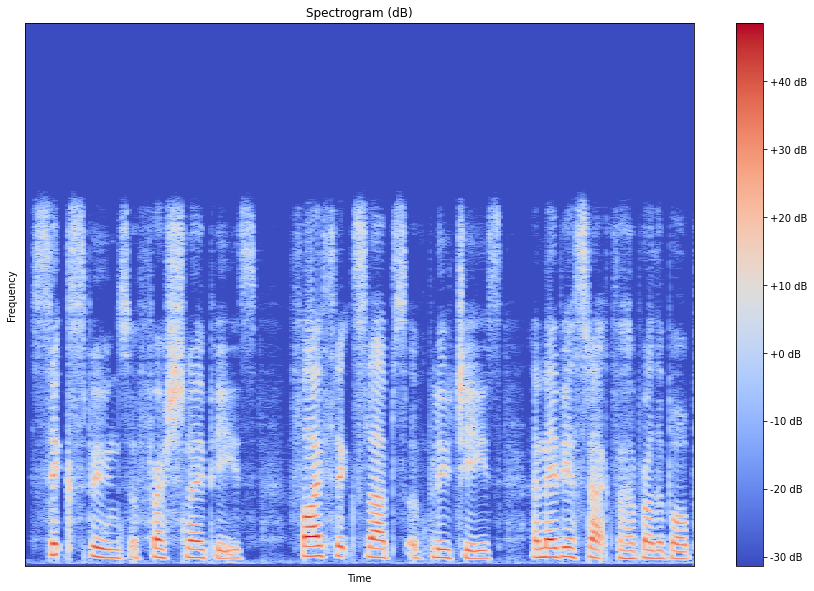

In [6]:
hop_length = 512  # 전체 frame 수
n_fft = 2048  # frame 하나당 sample 수

# STFT
stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)

# 복소공간 값 절댓값 취하기
magnitude = np.abs(stft)

# magnitude > Decibels 
log_spectrogram = librosa.amplitude_to_db(magnitude)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

###Mel spectrogram 생성하기
Mel-basis를 먼저 생성한뒤, stft로 구한 magnitude 값과 dot product를 수행하여 최종적으로 Mel-spectrogram을 생성할 수 있습니다.


**references**\
https://librosa.org/doc/main/generated/librosa.filters.mel.html

(80, 263) 1e-08 1.0 0.4367756


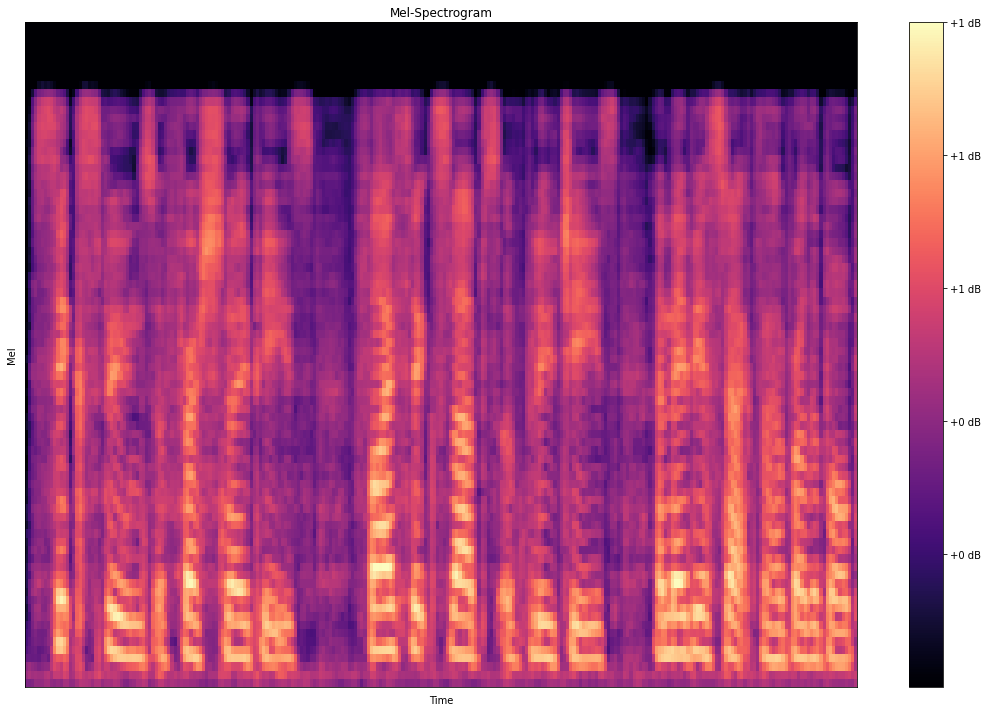

In [7]:
# Mel spectrogram 생성하기
n_mels = 80

# mel spectrogram
mel_basis = librosa.filters.mel(sr, n_fft, n_mels)  # (n_mels, 1+n_fft//2)
mel = np.dot(mel_basis, magnitude)  # (n_mels, t)

# to decibel
mel = 20 * np.log10(np.maximum(1e-5, mel))

# normalize
mel = np.clip((mel - 20 + 100) / 100, 1e-8, 1)

print(mel.shape, mel.min(),mel.max(),mel.mean())

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Mel")
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

#실습 진행하기

## Req. 1-1:	librosa 라이브러리를 활용하여 음성 불러오기


In [8]:
################################################################################
# TODO: librosa 라이브러리를 활용하여 음성 불러오기                                     #
################################################################################
test_audio = "/content/drive/My Drive/Colab Notebooks/SubPJT2_Voice_Conversion/jupyter/source/test.wav" 

sig, sr = librosa.load(test_audio, sr=16000, duration=3)
################################################################################
# TODO: librosa 라이브러리를 활용하여 음성 불러오기                                     #
################################################################################

#Test용 코드
print("shape of the waveform: ",sig.shape)
print("max value of the waveform: ", sig.max())

shape of the waveform:  (48000,)
max value of the waveform:  0.9768982


## Req. 1-2:	librosa 라이브러리를 활용하여 short time fourier transform 수행

shape of the output:  (513, 188)
max value of the output:  (107.52043-82.76717j)


Text(0.5, 1.0, 'Spectrogram (dB)')

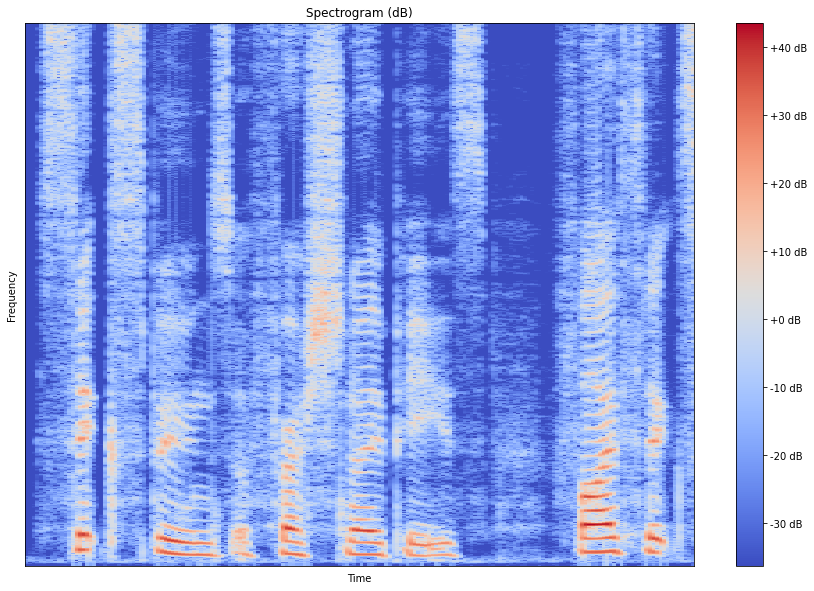

In [10]:
################################################################################
# TODO: librosa 라이브러리를 활용하여 short time fourier transform 수행               #
################################################################################
hop_length = 256  # 전체 frame 수
n_fft = 1024  # frame 하나당 sample 수

# STFT
stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length, window='hamm')
################################################################################
# TODO: librosa 라이브러리를 활용하여 short time fourier transform 수행               #
################################################################################

#Test용 코드
print("shape of the output: ", stft.shape)
print("max value of the output: ", stft.max())

# 복소공간 값 절댓값 취하기
magnitude = np.abs(stft)

# magnitude > Decibels 
log_spectrogram = librosa.amplitude_to_db(magnitude)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

## Req. 1-3:	librosa 라이브러리를 활용하여 Mel-spectrogram 생성

shape of the mel-spectrogram:  (128, 188)
max value of the mel-spectrogram:  0.98176676


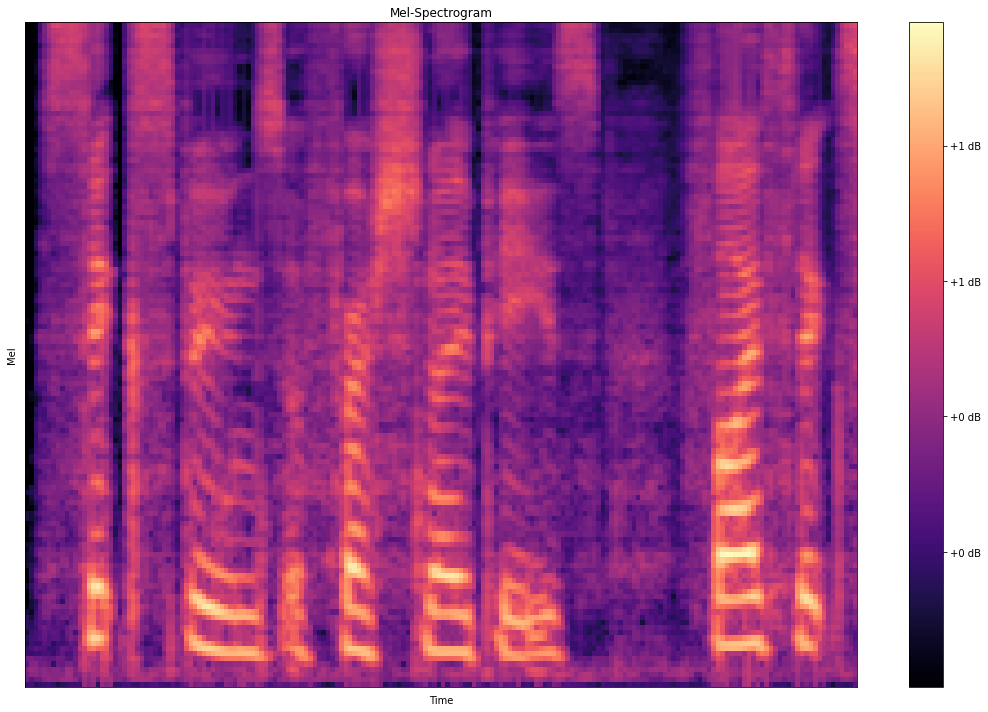

In [14]:
################################################################################
# TODO: librosa 라이브러리를 활용하여 Mel-spectrogram 생성                            #
################################################################################
# Mel spectrogram 생성하기
n_mels = 128
n_fft = 1024

# mel spectrogram
mel_basis = librosa.filters.mel(sr, n_fft, n_mels)  # (n_mels, 1+n_fft//2)
mel = np.dot(mel_basis, magnitude)  # (n_mels, t)

# to decibel
mel = 20 * np.log10(np.maximum(1e-5, mel))

# normalize
mel = np.clip((mel - 20 + 100) / 100, 1e-8, 1)
################################################################################
# TODO: librosa 라이브러리를 활용하여 Mel-spectrogram 생성                            #
################################################################################
#Test용 코드
print("shape of the mel-spectrogram: ", mel.shape)
print("max value of the mel-spectrogram: ", mel.max())

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Mel")
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()